In [43]:
# !pip install tensorflow


In [1]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[2]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

src_path


WindowsPath('C:/Users/Nasiba/Documents/1 Master Data Science/Projektpraktikum/WebScience24')

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from collections import Counter
#nlp = spacy.load("en_core_web_sm")
from nltk import word_tokenize
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from vector_functions import vectorize_word2vec, vectorize_glove, vectorize_glove_test_data, vectorize_word2vec_test_data
import nltk

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
from tensorflow.keras.utils import to_categorical



#### Beladung der Daten

In [3]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/mixed_dataset/train_cleaned.csv'))

df_cleaned = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)

source_filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/mixed_dataset/test_cleaned.csv'))

df_cleaned_test = pd.read_csv(source_filepath_name_test, encoding='utf-8', index_col=0)

df_cleaned.head(1)

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
id,,,,,,
8886,0,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it,cinema award final rehearsal gear evening butterfly stage hope like,1,"['#cinemaaawards', '#butterflies', '#stage']",NaN


### Vektorisierung

#### GloVe 

In [4]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.6B.200d.txt'))


X_train_vectors, X_test_vectors, y_train, y_test, glove_embeddings = vectorize_glove(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)

X_test_data_vectors , y_test_data, glove_embeddings = vectorize_glove_test_data(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)
c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


### Modell aufbauen 

##### Die Modelleingaben überprüfen

In [5]:
print(X_train_vectors.shape)
print(X_test_vectors.shape)
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_vectors.shape)
print(len(np.unique(y_test)))

(14124, 50, 100)
(6054, 50, 100)
14124
50
100
2
(6054, 50, 100)
2


#### One-Hot-Encoding der Labels

In [6]:

y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)
y_test_onehot_data = to_categorical(y_test_data, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot_data)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


##### Modellinitialisierung

In [11]:

# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='softmax'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#####  Modell trainieren

In [12]:

history = model.fit(
    X_train_vectors, y_train_onehot,
    validation_data=(X_test_vectors, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9283 - loss: 0.2489 - val_accuracy: 0.9483 - val_loss: 0.1527
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9398 - loss: 0.1615 - val_accuracy: 0.9500 - val_loss: 0.1419
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9496 - loss: 0.1396 - val_accuracy: 0.9547 - val_loss: 0.1353
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9483 - loss: 0.1411 - val_accuracy: 0.9480 - val_loss: 0.1441
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9510 - loss: 0.1373 - val_accuracy: 0.9577 - val_loss: 0.1207
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9611 - loss: 0.1096 - val_accuracy: 0.9571 - val_loss: 0.1201
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9596 - loss: 0.1092 - val_accuracy: 0.9498 - val_loss: 0.1568
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9627 - loss: 0.1064 - 

### Modell bewerten

In [13]:

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_data_vectors, y_test_onehot_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Vorhersagen auf Testdaten
predictions = model.predict(X_test_data_vectors)
predicted_classes = np.argmax(predictions, axis=1)


# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot_data, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)


631/631 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9712 - loss: 0.0820
Test Loss: 0.07977746427059174
Test Accuracy: 0.9729903936386108
631/631 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99     18847
     Class 1       0.90      0.67      0.76      1331

    accuracy                           0.97     20178
   macro avg       0.94      0.83      0.88     20178
weighted avg       0.97      0.97      0.97     20178



[[18746   101]
 [  444   887]]


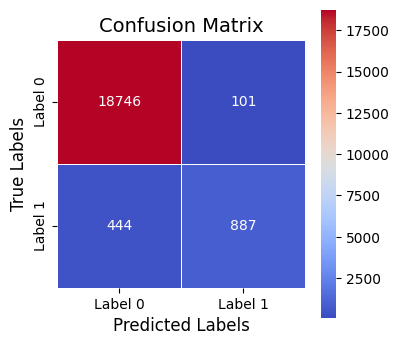

In [14]:
cm = confusion_matrix(np.argmax(y_test_onehot_data, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

### Testdaten labeln

In [ ]:
source_filepath_name_test_wht_label = os.path.abspath(os.path.join(src_path, 'data/mixed_dataset/test.csv'))

df_test = pd.read_csv(source_filepath_name_test, encoding='utf-8', index_col=0)

df_test.head(1)